### Python functions to perform Visual Impact Assessment (VIA)
- Siddharth Ramavajjala, Department of Geography, University of Wisconsin - Madison

In [1]:
import geopandas as gpd
import pandas as pd
from shapely import Point, Polygon
import matplotlib.pyplot as plt
import pyproj
from osgeo import gdal
import numpy as np
import rioxarray as rxr
from shapely import box
import whitebox
import rasterio as rio
from rasterio.plot import show,show_hist
wbt = whitebox.WhiteboxTools()
from osgeo import gdal

In [2]:
# Read United States Wind Turbine Database CSV file
# URL: https://www.sciencebase.gov/catalog/item/6001e327d34e592d8671fae0 (from USGS)
gdf = gpd.read_file("datasets/uswtdb.csv")
# Analyze and understand meaning columns
gdf.head(1)

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,geometry
0,3123233,40-097764,2021-WTW-7887-OE,,,OK,Ellis County,40045,25 Mile Creek,2022,...,180,0,,1,3,1/4/2023,Digital Globe,-99.775963,36.458096,None


In [3]:
# geom() return Point object based on longitude('xlong') and latitude('ylat')
def geom(x):
    """Function to create a Point geometry object and insert into GeoDatFrame"""
    return Point(x['xlong'], x['ylat'])
# Update the geometry column using lambda function
gdf["geometry"] = gdf.apply(lambda x: geom(x), axis=1)
# Print head to check if the column is updated correctly
gdf.head(1)

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,geometry
0,3123233,40-097764,2021-WTW-7887-OE,,,OK,Ellis County,40045,25 Mile Creek,2022,...,180,0,,1,3,1/4/2023,Digital Globe,-99.775963,36.458096,POINT (-99.77596 36.45810)


In [4]:
# gdf.crs property check whether a coordinate reference system (CRS) is assigned
if gdf.crs == None:
    print("No CRS")

No CRS


In [6]:
# If no CRS is assigned, use EPSG:4326 as long, lat values are in 3 Dimensional coordinate system
gdf = gdf.set_crs('epsg:4326')
# Use gdf.explore() to interactively map and view the point locations of wind turbines

In [7]:
# Print unique state values for scoping
gdf['t_state'].unique()

array(['OK', 'CA', 'IA', 'MA', 'OH', 'MN', 'IL', 'NE', 'WY', 'KS', 'PA',
       'TX', 'IN', 'NC', 'NM', 'NH', 'MI', 'NY', 'ND', 'SD', 'CO', 'HI',
       'PR', 'NJ', 'WV', 'OR', 'AK', 'WA', 'MT', 'ME', 'AR', 'RI', 'WI',
       'MO', 'VT', 'TN', 'ID', 'UT', 'VA', 'MD', 'AZ', 'GU', 'CT', 'NV',
       'DE'], dtype=object)

In [8]:
# Print count of unique counties to scope magnitude of dataset
gdf['t_county'].nunique()

569

In [9]:
# Create a dictionary and store Wind Turbine count corresponding to each state
print("State \tWind Turbine Count")
wtb_dict = {}
for state in list(gdf['t_state'].unique()):
    print(f'{state}\t{gdf["t_state"].value_counts()[state]}')
    wtb_dict[state] = gdf["t_state"].value_counts()[state]

State 	Wind Turbine Count
OK	5474
CA	5989
IA	6293
MA	92
OH	499
MN	2744
IL	3622
NE	1523
WY	1463
KS	3962
PA	752
TX	18552
IN	1614
NC	105
NM	1952
NH	84
MI	1637
NY	1233
ND	2095
SD	1367
CO	2835
HI	129
PR	63
NJ	6
WV	419
OR	2122
AK	142
WA	1826
MT	809
ME	417
AR	1
RI	35
WI	452
MO	1107
VT	73
TN	18
ID	541
UT	208
VA	2
MD	80
AZ	321
GU	1
CT	3
NV	68
DE	1


In [10]:
# Sort the dictionary values in ascending order and store them back
sorted_wtb_counts = sorted(wtb_dict.items(), key=lambda x:x[1])
wtb_dict = dict(sorted_wtb_counts)

In [11]:
# Print to view wind turbine count by state in ascending order
wtb_dict

{'AR': 1,
 'GU': 1,
 'DE': 1,
 'VA': 2,
 'CT': 3,
 'NJ': 6,
 'TN': 18,
 'RI': 35,
 'PR': 63,
 'NV': 68,
 'VT': 73,
 'MD': 80,
 'NH': 84,
 'MA': 92,
 'NC': 105,
 'HI': 129,
 'AK': 142,
 'UT': 208,
 'AZ': 321,
 'ME': 417,
 'WV': 419,
 'WI': 452,
 'OH': 499,
 'ID': 541,
 'PA': 752,
 'MT': 809,
 'MO': 1107,
 'NY': 1233,
 'SD': 1367,
 'WY': 1463,
 'NE': 1523,
 'IN': 1614,
 'MI': 1637,
 'WA': 1826,
 'NM': 1952,
 'ND': 2095,
 'OR': 2122,
 'MN': 2744,
 'CO': 2835,
 'IL': 3622,
 'KS': 3962,
 'OK': 5474,
 'CA': 5989,
 'IA': 6293,
 'TX': 18552}

Dictionary to Dataframe (<a href = "https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframem">Link</a>)

In [91]:
wind_turbines_df = pd.DataFrame(wtb_dict.items(), columns=['State','Turbines'])
wind_turbines_df.head(1)

,State,Turbines
0,AR,1


In [93]:
tot = wind_turbines_df['Turbines'].sum()
tot

72731

In [96]:
wind_turbines_df['Share'] = wind_turbines_df['Turbines'].apply(lambda x: round((x/tot)*100,0))
wind_turbines_df.head(1)

,State,Turbines,Share
0,AR,1,0.0


In [99]:
share_mean = wind_turbines_df['Share'].mean()
share_mean = round(share_mean,2)
share_mean

2.27

In [100]:
wind_turbines_above_mean = wind_turbines_df [wind_turbines_df['Share']>share_mean]

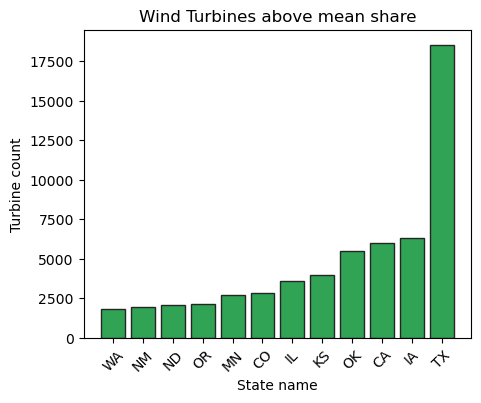

In [115]:
plt.rcParams['figure.figsize'] = [5, 4]
# Plot bar chart for ranking each state
plt.bar(wind_turbines_above_mean['State'], wind_turbines_above_mean['Turbines'], color='#31a354', edgecolor='#252525')
# Adjust the rotation angle to 90 degrees (To avoid label clutter)
plt.xticks(rotation=45)  
plt.title('Wind Turbines above mean share')
plt.xlabel('State name')
plt.ylabel('Turbine count')
# Show the plot
plt.show()

### Wind Turbines in Texas

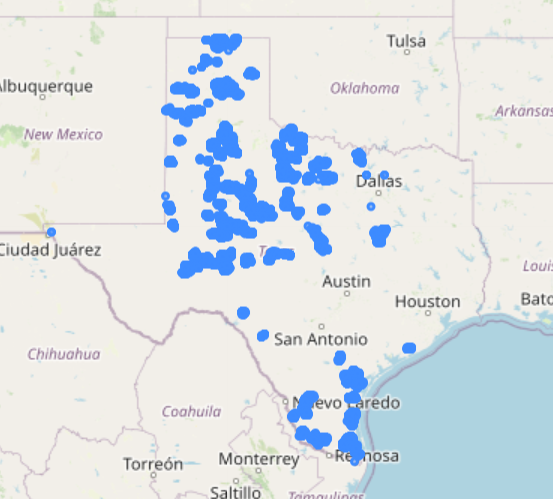

### Blackjack Creek Project 
- Bee County, Texas

In [13]:
gdf_tx_aoi = gdf[(gdf['t_state']=='TX') & (gdf['t_county']=='Bee County') & (gdf['p_name']=='Blackjack Creek')]

In [14]:
gdf_tx_aoi.explore()

In [15]:
print(f'Xmax:{gdf_tx_aoi["xlong"].max()} \tYmax:{gdf_tx_aoi["ylat"].max()} \nXmin:{gdf_tx_aoi["xlong"].min()} \tYmin:{gdf_tx_aoi["ylat"].min()}')

Xmax:-97.573631 	Ymax:28.308331 
Xmin:-97.461571 	Ymin:28.221092


Click here <a href = "https://apps.nationalmap.gov/downloader/#/">USGS TNM Downloader</a>  to download the DEM data using bounding box coordinates (aforementioned)

In [16]:
gdf_tx_aoi.columns.values

array(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id', 't_state',
       't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap',
       't_manu', 't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh',
       'retrofit', 'retrofit_year', 't_conf_atr', 't_conf_loc',
       't_img_date', 't_img_srce', 'xlong', 'ylat', 'geometry'],
      dtype=object)

In [17]:
gdf_tx_aoi.head(1)

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,geometry
5071,3119713,48-186736,2019-WTW-9999-OE,,,TX,Bee County,48025,Blackjack Creek,2022,...,185.5,0,,1,3,2/17/2022,Digital Globe,-97.565788,28.285681,POINT (-97.56579 28.28568)


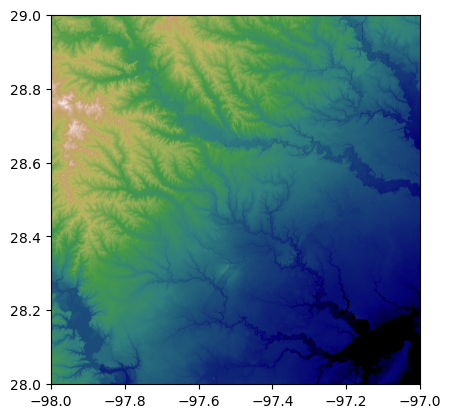

In [18]:
with rio.open('datasets/USGS_13_n29w098_20211103.tif') as dst:
    show(dst, cmap = 'gist_earth')

In [19]:
with rio.open('datasets/USGS_13_n29w098_20211103.tif') as dst:
    meta = dst.meta.copy()
    output_crs = dst.crs.to_epsg()

In [20]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999999.0,
 'width': 10812,
 'height': 10812,
 'count': 1,
 'crs': CRS.from_epsg(4269),
 'transform': Affine(9.259259269220166e-05, 0.0, -98.00055555629325,
        0.0, -9.259259269220166e-05, 29.000555555895062)}

In [21]:
type(output_crs), output_crs

(int, 4269)

In [22]:
def min_coords(df):
    return (df['xlong'].min(), df['ylat'].min())
def max_coords(df):
    return (df['xlong'].max(), df['ylat'].max())

In [23]:
def reproj_coords(min_coords, max_coords, output_crs,input_crs=4326):
    source_crs = pyproj.CRS.from_epsg(input_crs)
    dest_crs = pyproj.CRS.from_epsg(output_crs)
    transformer = pyproj.Transformer.from_crs(source_crs, dest_crs, always_xy = True)
    xmin, ymin = transformer.transform(min_coords[0], min_coords[1])
    xmax, ymax = transformer.transform(max_coords[0], max_coords[1])
    return (xmin, ymin, xmax, ymax)

In [24]:
min_coords = min_coords(gdf_tx_aoi)
max_coords = max_coords(gdf_tx_aoi)

In [25]:
min_coords, max_coords

(('-97.461571', '28.221092'), ('-97.573631', '28.308331'))

In [26]:
reproj_coords(min_coords,max_coords,output_crs,4326)

(-97.46156572539842, 28.221094225596413, -97.57362590570015, 28.30833310252822)

In [27]:
gdf_tx_aoi = gdf_tx_aoi.to_crs('EPSG:4269')
gdf_tx_aoi.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [26]:
gdf_tx_aoi.to_file('datasets/tx_aoi.shp')

C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_8076\1591735196.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_tx_aoi.to_file('datasets/tx_aoi.shp')


### Clipping raster to extent

In [28]:
bbox = reproj_coords(min_coords,max_coords,output_crs,4326)
bbox

(-97.46156572539842, 28.221094225596413, -97.57362590570015, 28.30833310252822)

In [29]:
def clip_raster(raster_in, raster_out, bbox, output_crs):
    input_data = rxr.open_rasterio(raster_in)
    clip_box = (box(*bbox))
    clip_data = input_data.rio.clip([clip_box])
    clip_data.rio.to_raster(raster_out)

In [30]:
clip_raster('datasets/USGS_13_n29w098_20211103.tif','datasets/clip_raster.tif', bbox, output_crs)

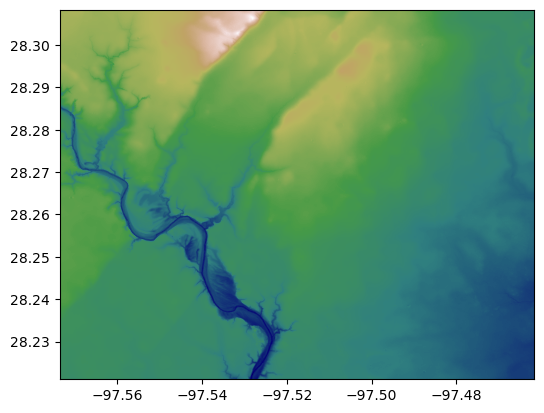

In [31]:
with rio.open('datasets/clip_raster.tif') as dst:
    show(dst, cmap = 'gist_earth')

Define the observer point coordinates
- observer_x = -97.46156572539842
- observer_y = 28.221094225596413

Set verbose off to avoid printing of text when using Whitebox (Source: <a href="https://www.whiteboxgeo.com/manual/wbt_book/python_scripting/tool_output.html">Click here</a>)

In [32]:
# Set working directory
wbt.set_working_dir(r'C:\Users\Sidrcs\Documents\Github\Visual_Impact_Assessment\datasets')
wbt.set_verbose_mode(False)

0

In [33]:
# Whitebox viewshed DEM, TX AoI Wind Turbine, Viewshed Raster
wbt.viewshed('clip_raster.tif', 'tx_aoi.shp', 'viewshed_out.tif', height=2.0)

0

In [70]:
viewshed = rio.open('datasets/viewshed_out.tif')

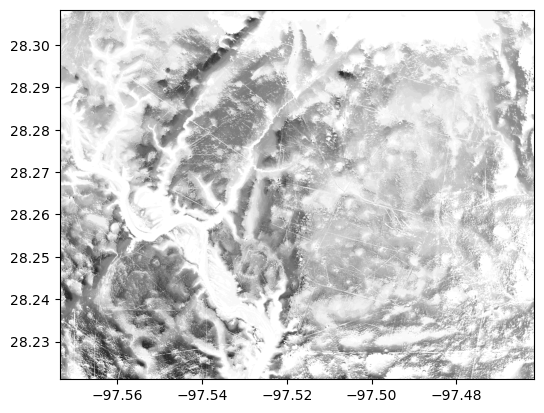

<Axes: >

In [80]:
show(viewshed, cmap='gist_yarg')

In [77]:
meta_viewshed = viewshed.meta
meta_viewshed

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999999.0,
 'width': 1210,
 'height': 942,
 'count': 1,
 'crs': CRS.from_epsg(4269),
 'transform': Affine(9.259259269219985e-05, 0.0, -97.57361111138951,
        0.0, -9.259259269220041e-05, 28.30833333292816)}

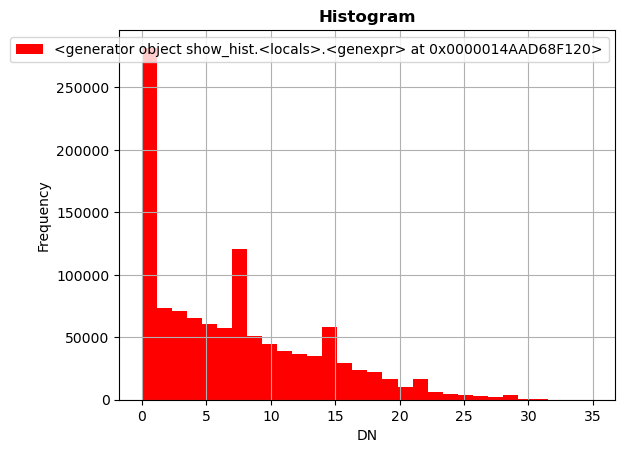

In [37]:
with rio.open('datasets/viewshed_out.tif') as dst:
    show_hist(dst, bins=30, stacked=False)

In [38]:
def mile2meter(mile):
    return (1609.34*mile)

In [51]:
gdf_tx_aoi = gdf_tx_aoi.to_crs(3857)
gdf_tx_aoi_buffer_half_mile = gdf_tx_aoi.geometry.buffer(mile2meter(0.5))
gdf_tx_aoi_buffer_four_mile = gdf_tx_aoi.geometry.buffer(mile2meter(4))
gdf_tx_aoi_buffer_ten_mile = gdf_tx_aoi.geometry.buffer(mile2meter(10))

In [52]:
geom_half_mile = gdf_tx_aoi_buffer_half_mile.geometry.unary_union
geom_four_mile = gdf_tx_aoi_buffer_four_mile.geometry.unary_union
geom_ten_mile = gdf_tx_aoi_buffer_ten_mile.geometry.unary_union

Trick used below is obtained from Stack Over Flow (<a href="https://gis.stackexchange.com/questions/285595/buffer-with-dissolve-geopandas-unary-union-multipolygon">link</a>)

In [63]:
s0 = gpd.GeoDataFrame(geometry=[geom_half_mile])

<Axes: >

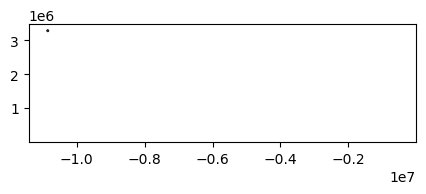

In [85]:
fig, ax = plt.subplots(figsize=(5, 5))
s2.plot(ax=ax, facecolor='none', edgecolor='#252525')
s1.plot(ax=ax, facecolor='none', edgecolor='#252525')
s0.plot(ax=ax, facecolor='none', edgecolor='#252525')

In [87]:
((135-40)/40)*100

237.5